In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline

plt.rcParams["figure.figsize"] = [13,5]

In [3]:
# ---------------------------------------------------------------
# Load Data
# ---------------------------------------------------------------
input_dir = "./data/"

train_file = os.path.join(input_dir, "train.csv")
test_file = os.path.join(input_dir, "test.csv")

train = pd.read_csv(train_file)
test = pd.read_csv(test_file)

X = train.iloc[:,:-1]
y = train.iloc[:,-1]


# ---------------------------------------------------------------
# Map features
# ---------------------------------------------------------------
# Map categorical variables with one-hot encoding
X_transformed = pd.get_dummies(X)
print(X_transformed.shape)

# Drop NAs (because regression tree can't handle NAs)
X_transformed.dropna(axis=1, how='any', inplace=True)
print(X_transformed.shape)


# ---------------------------------------------------------------
# Split to train and test set
# ---------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2)

print("feature:", X_train.shape[1])
print("num train samples:", X_train.shape[0])
print("num valid samples:", X_test.shape[0])

(1460, 289)
(1460, 286)
feature: 286
num train samples: 1168
num valid samples: 292


## Random Forest

In [4]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 30, random_state=1)
rf = rf.fit(X_train, y_train)

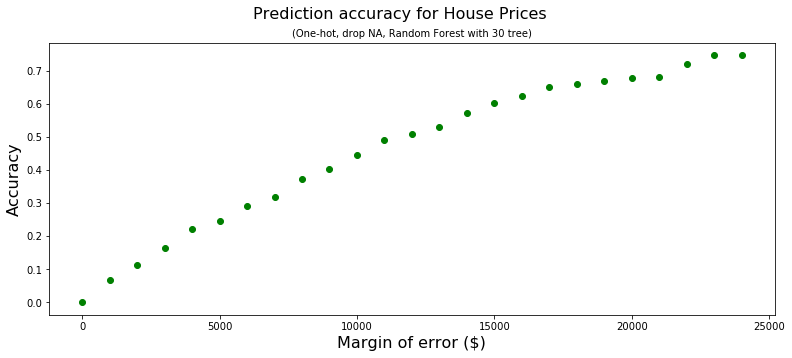

In [5]:
def evaluation(clf, margin = 5000):
    def _eval(m):
        y_hat = clf.predict(X_test)
        answer_within_range = (y_test+m > y_hat) & (y_hat > y_test-m)
        return(sum(answer_within_range) / len(answer_within_range))
    
    if type(margin) in [list, range]:
        return([_eval(m) for m in margin])
    else:
        return(_eval(margin))

    
# ---------------------------------------------------------------    
# Evaluate
# ---------------------------------------------------------------
margins = range(0, 25000, 1000)

plt.plot(margins, evaluation(rf, margins), 'go')
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Margin of error ($)', fontsize=16)
plt.suptitle('Prediction accuracy for House Prices', fontsize=16)
plt.title('(One-hot, drop NA, Random Forest with 30 tree)', fontsize=10)

In [7]:
evaluation(rf, 5000)

0.24657534246575341

## Extremely random trees

- [Scikit-learn description](http://scikit-learn.org/stable/modules/ensemble.html#extremely-randomized-trees)

> In extremely randomized trees (see ExtraTreesClassifier and [ExtraTreesRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html#sklearn.ensemble.ExtraTreesRegressor) classes), randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias:

In [8]:
from sklearn.ensemble import ExtraTreesRegressor

etr = ExtraTreesRegressor(n_estimators=30, random_state=1)
etr = etr.fit(X_train, y_train)

## Better predictive abilities with Random Forest

In [9]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=1)
dtr = dtr.fit(X_train, y_train)

In [10]:
from sklearn.ensemble import BaggingClassifier
bag = BaggingClassifier(n_estimators = 30, random_state=1)
bag = bag.fit(X_train, y_train)

In [11]:
margins = range(0, 25000, 1000)

evals = {}

evals['dtr'] = evaluation(dtr, margins)
evals['bag'] = evaluation(bag, margins)
evals['rf'] = evaluation(rf, margins)
evals['etr'] = evaluation(etr, margins)

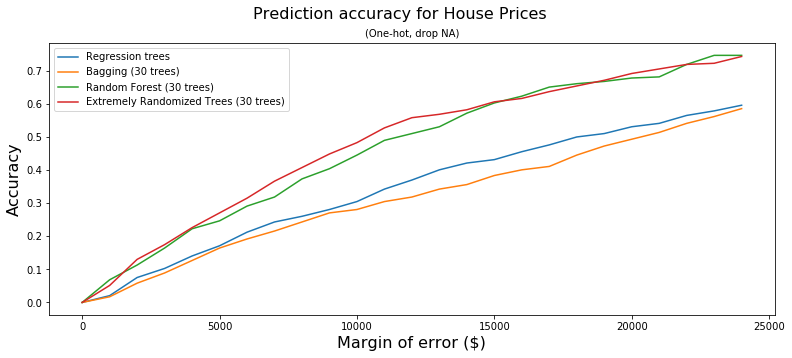

In [12]:
x1 = plt.plot(margins, evals['dtr'], label="Regression trees")
x2 = plt.plot(margins, evals['bag'], label="Bagging (30 trees)")
x3 = plt.plot(margins, evals['rf'], label="Random Forest (30 trees)")
x4 = plt.plot(margins, evals['etr'], label="Extremely Randomized Trees (30 trees)")

plt.legend(loc='upper left')

plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Margin of error ($)', fontsize=16)
plt.suptitle('Prediction accuracy for House Prices', fontsize=16)
plt.title('(One-hot, drop NA)', fontsize=10)